### 3D Particle simulation, from H. Talbot

In [1]:
import matplotlib.pylab as plt
import numpy as np
import numpy.random
import scipy
import skimage
import pymrt as mrt
import raster_geometry as rg
#import pymrt.geometry


 ____        __  __ ____ _____
|  _ \ _   _|  \/  |  _ \_   _|
| |_) | | | | |\/| | |_) || |
|  __/| |_| | |  | |  _ < | |
|_|    \__, |_|  |_|_| \_\|_|
       |___/



In [2]:
# constants
def setParameters(shapeimg=350,# size of the image
                  radius=80, # radius of HR ball
                  step=0.1, # relative to 1
                  slices=7,# number of 2D samples
                  zoomfactor=0.1,
                  approxorder=1):
    return(shapeimg,radius,step,slices,zoomfactor,approxorder)

# globals, avoid using them
shapeimg,radius,step,slices,zoomfactor,approxorder = setParameters()

In [3]:
# perfect sphere
ball1=rg.sphere(shapeimg,radius,position=[0.5,0.7,0.7]).astype(float)
ball1.shape

(350, 350, 350)

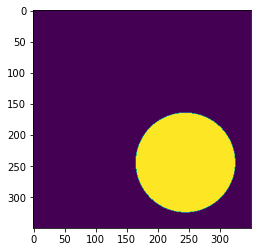

In [4]:
plt.figure()
plt.imshow(ball1[int(shapeimg/2),:,:])
plt.show()

In [5]:
## Random placement, then downsample
center=np.random.normal(loc=0.5,scale=step,size=3)

In [6]:
ball1=rg.sphere(shapeimg,radius,position=center).astype(float)
print("center=",center)

center= [0.56926965 0.42330954 0.37782017]


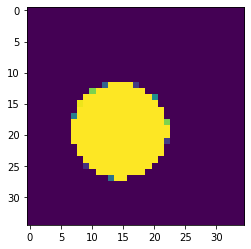

In [7]:
from scipy.ndimage.interpolation import zoom
smallball1=zoom(ball1,zoomfactor,order=1)
plt.figure()
plt.imshow(zoom(ball1[:,:,int(shapeimg*0.4)],zoomfactor,order=1))
plt.show()

In [8]:
import logging, sys
logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)
#logging.debug('A debug message!')
#logging.info('We processed %d records', len(processed_records))

def sampleBall(debug=True):
    # parameters as local variables
    shapeimg,radius,step,slices,zoomfactor,approxorder = setParameters()
    
    n=slices
    slicelist = ((np.arange(n)-(n-1)/2)*(2*radius/n)+(shapeimg/2)).astype(int)
    logging.debug("slicelist=%s",str(slicelist))
    disklist = []
    centers = []
    for i in range(n):
        # create high resolution ball randomly shifted
        center=np.random.normal(loc=0.5,scale=step,size=3)
        logging.debug("center=%s",str(center))
        hrBall=rg.sphere(shapeimg,radius,position=center).astype(float)
        lrDisk=zoom(hrBall[slicelist[i],:,:],zoomfactor,order=approxorder)
        disklist.append(lrDisk)
        centers.append(center)
    return(centers,slicelist, np.array(disklist))

DEBUG:root:slicelist=[106 129 152 175 197 220 243]
DEBUG:root:center=[0.39827144 0.43838302 0.50368179]
DEBUG:root:center=[0.63389488 0.4663529  0.57185938]
DEBUG:root:center=[0.42328149 0.47820343 0.45209793]
DEBUG:root:center=[0.34832387 0.55097318 0.65326686]
DEBUG:root:center=[0.45248412 0.46066516 0.49397526]
DEBUG:root:center=[0.63621468 0.59425554 0.48150488]
DEBUG:root:center=[0.60546149 0.25892926 0.55506566]


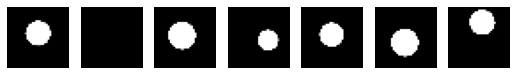

In [9]:
centers,slicelist,mysamples=sampleBall()
def imshown(imlist,cmap="gray"):
    w=10
    h=10
    fig=plt.figure(figsize=(9, 2))
    columns = len(imlist)
    rows = 1
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(imlist[i-1],cmap=cmap)
        plt.axis('off')

    plt.show()
    
imshown(mysamples,cmap="gray")

## Simulation and estimation

(350, 350, 350)


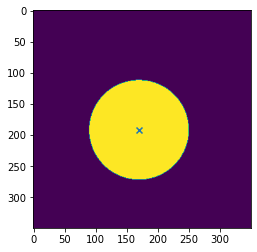

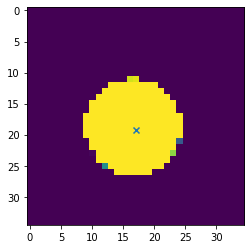

In [10]:
# Parameters

# Dimension of the 3D image
Nx,Ny,Nz = (350,350,350)

# Radius and center of the sphere
Radius = 80
np.random.seed(42)
center=np.random.normal(loc=0.5,scale=step,size=3)

# Particle simulation
# perfect sphere
ball =rg.sphere((Nx,Ny,Nz),Radius,position=center).astype(float)
print(ball.shape)

# Zoom
# Zoom factor
zoomfactor = 0.1
nx = int(zoomfactor*Nx)
ny = int(zoomfactor*Ny)
nz = int(zoomfactor*Nz)
R = Radius*zoomfactor


from scipy.ndimage.interpolation import zoom

particle = zoom(ball,zoomfactor,order=1)

plt.figure()
plt.imshow(ball[:,:,int(Nz*center[2])])
plt.scatter([Nx*center[1]],[Ny*center[0]], marker="x")
plt.show()


plt.figure()
plt.imshow(particle[:,:,int(nz*center[2])])
plt.scatter([nx*center[1]],[ny*center[0]], marker="x")
plt.show()

# Diagonal of the frames
d = np.sqrt(nx**2+ny**2)

# z-coordinates of the frames
frames  = np.arange(0,nz)
# Number of frames
m = len(frames)


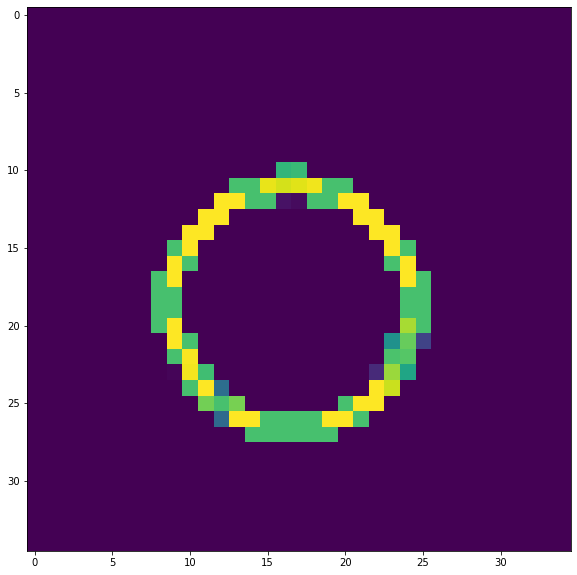

In [205]:
# Total variation 3D matrix of the image frames
def W_mat(image, frames):
    nx,ny,nz = image.shape
    nz = len(frames)
    W = np.zeros((nx,ny,nz))
    for i in range(nx):
        for j in range(ny):
            k_translated = 0
            for k in frames:
                varX = 0
                varY = 0
                if i==0:
                    varX += (image[i+1,j,k]-image[i,j,k])**2
                elif i==nx-1:
                    varX += (image[i-1,j,k]-image[i,j,k])**2
                else:
                    varX += (image[i-1,j,k]-image[i,j,k])**2+(image[i+1,j,k]-image[i,j,k])**2
                if j==0:
                    varY += (image[i,j+1,k]-image[i,j,k])**2
                elif j==ny-1:
                    varY += (image[i,j-1,k]-image[i,j,k])**2
                else:
                    varY += (image[i,j-1,k]-image[i,j,k])**2+(image[i,j+1,k]-image[i,j,k])**2
                W[i,j,k_translated] = np.sqrt(varX+varY)
                k_translated +=1
    return W


plt.figure(figsize=(15,10))
plt.imshow(W_mat(particle,frames)[:,:,int(nz*center[2])])


In [12]:
# Objective function
def objective_function(image,frames):
    nx,ny,nz = image.shape
    m = len(frames)
    W = W_mat(image,frames)
    def obj(alpha,beta,gamma,xi,eta):
        res = 0
        for k in range(m):
            for i in range(nx):
                for j in range(ny):
                    res += W[i,j,frames[k]]*(-2*i*alpha -2*j*beta + xi - eta[k] +i**2+j**2)**2
        return res/2
    return obj



obj = objective_function(particle,frames)
print(obj(10,10,10,10,np.ones(m)))

7311993.319739506


In [13]:
# Keeping only frames intersecting the sphere

def intersecting_frames(image,frames):
    start = -1
    end = -1
    index = 0
    m = len(frames)
    while end<0 and index<m:
        M = np.amax(image[:,:,frames[index]])
        if M>0 and start<0:
            start = index
        if start >= 0 and M==0:
            end = index
        index+=1
    if end<0:
        end = m
    return frames[start:end]

print(intersecting_frames(particle, frames))
print(np.amax(particle[:,:,11]))
print(np.amax(particle[:,:,12]))


framesInter = intersecting_frames(particle, frames)
mInter = len(framesInter)
print(mInter)


[12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
0.0
1.0
15


In [14]:
# Problem with cvxpy
import cvxpy as cp

# Variables

alpha = cp.Variable(1)
beta = cp.Variable(1)
gamma = cp.Variable(1)
xi = cp.Variable(1)
eta = cp.Variable(mInter)

# Objective
obj = objective_function(particle,framesInter)

objective = cp.Minimize(obj(alpha,beta,gamma,xi,eta))

# Constraints
constraints = [alpha**2+beta**2-xi <= 0, xi - d**2 <= 0, -eta <= 0, eta+(gamma-framesInter)**2 - R**2 <= 0]


# Problem
prob = cp.Problem(objective,constraints)


IndexError: index 15 is out of bounds for axis 2 with size 15

In [ ]:
# Solving
prob.solve(solver = cp.ECOS, verbose = True, max_iters=100)

print("Optimal value", prob.value)
print("Status :", prob.status)

print("alpha = ", alpha.value) 
print("beta = ", beta.value) 
print("gamma = ", gamma.value) 

print("Real center: ", center*nx)

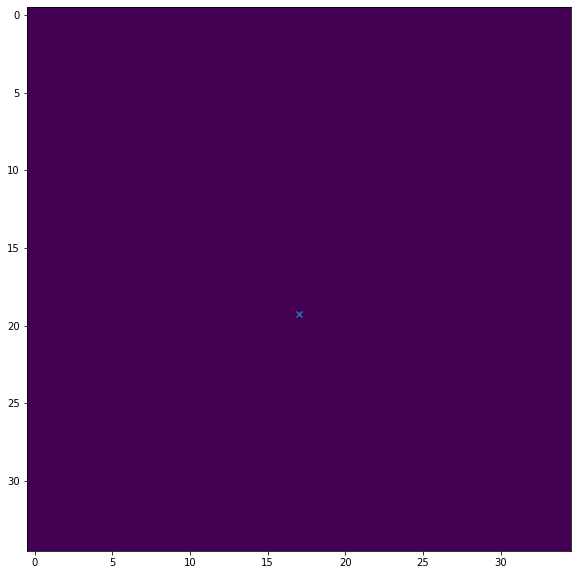

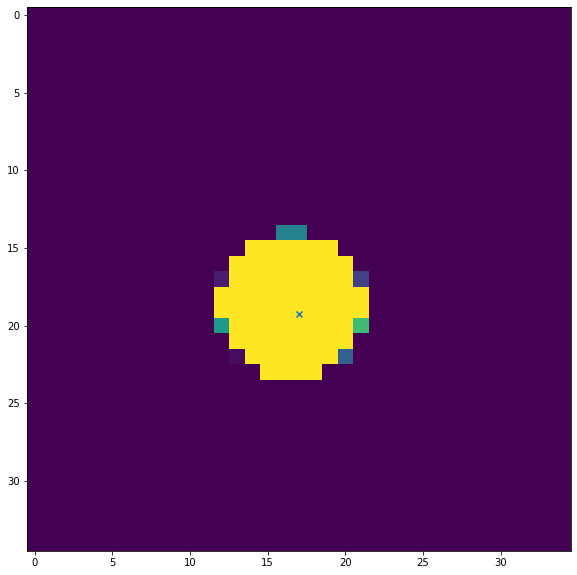

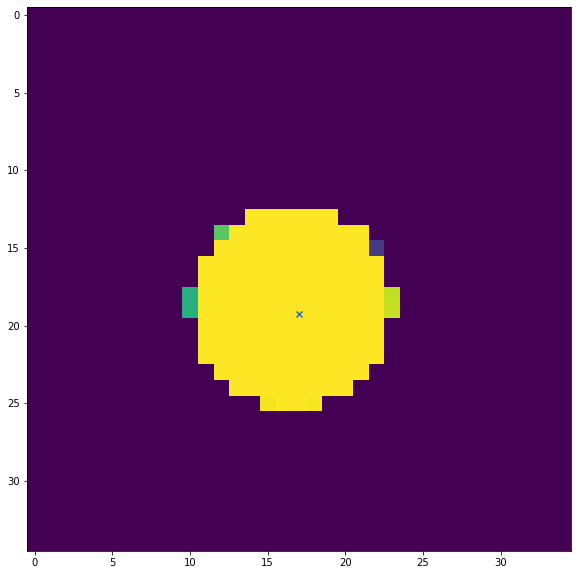

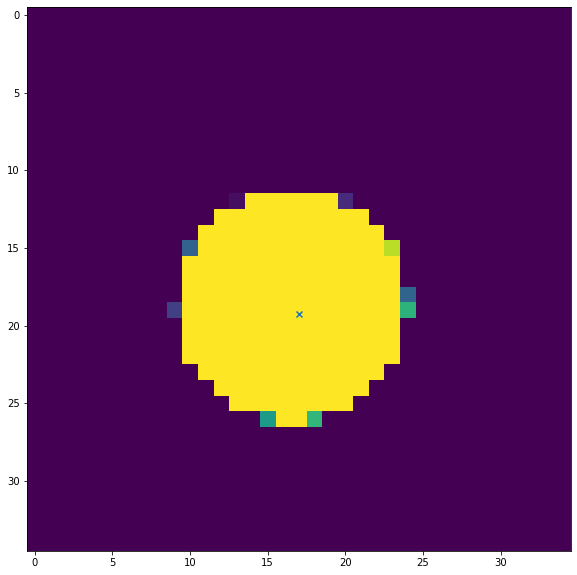

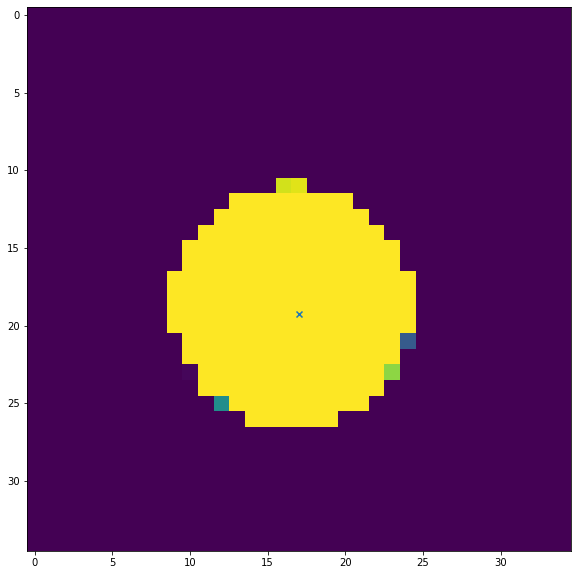

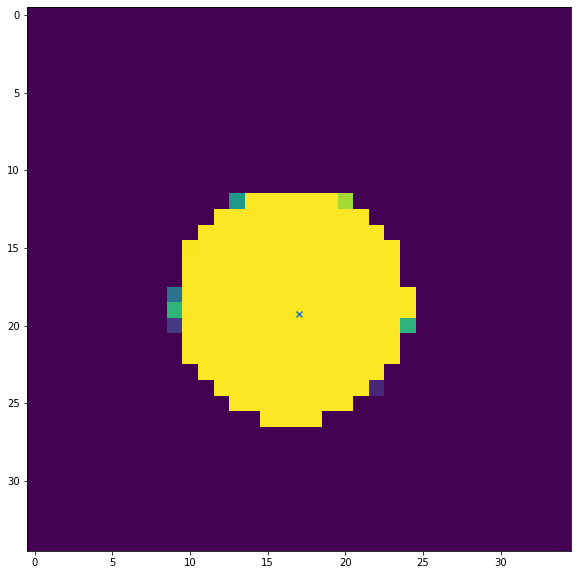

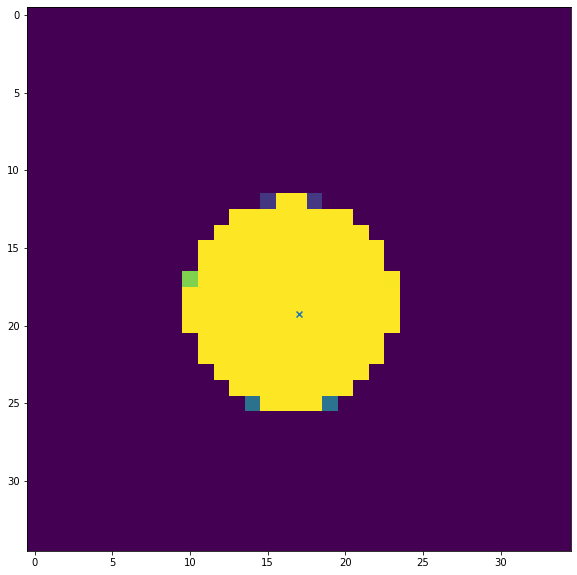

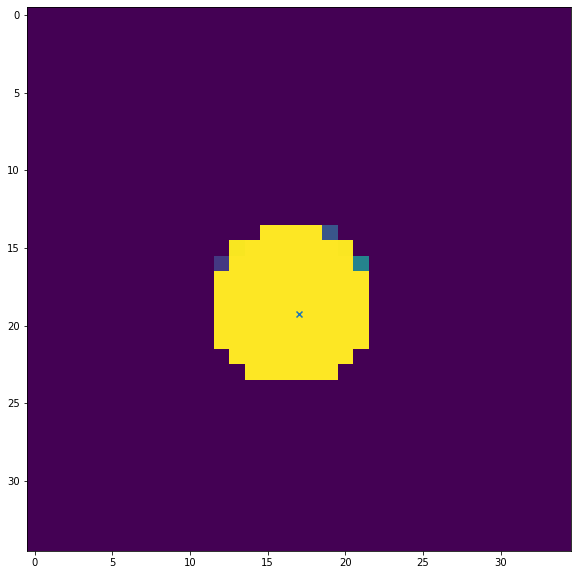

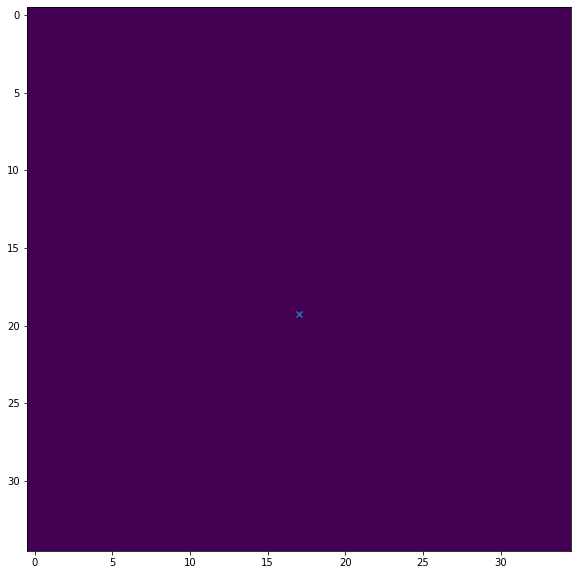

In [15]:
Z = int(nz*center[2])

for i in range(-8,9,2):
    plt.figure(figsize=(20,10))
    plt.imshow(particle[:,:,Z+i])
    plt.scatter([nx*center[1]],[ny*center[0]], marker="x")
    plt.scatter([beta.value],[alpha.value], marker="x", color='red')
    plt.show()

In [133]:
def Create_A_and_b(W):
    "Cette fonction permet de creer la matrice A de taille n * 4+m et le vecteur b de taille n"
    
    #Convertir la matrice W en 2D -- Taille: n * s(3) avec n = s(1)*s(2)
    s1 = np.size(W,0)
    s2 = np.size(W,1)
    s3 = np.size(W,2)
    
    W_2D = W.reshape(s1*s2, s3)

#Definir le vecteur f_1 de taille 4+m (vecteur de 0 sauf le 1er element est 1)    
    f_1 = np.zeros((4+s3,1))
    f_1[0] = 1   
    
#Definir le vecteur f_2 de taille 4+m (vecteur de 0 sauf le 2eme element est 1)
    f_2 = np.zeros((4+s3,1))
    f_2[1] = 1    
    
#Definir le vecteur f_3 de taille 4+m (vecteur de 0 sauf le 3eme element est 1)
    f_3 = np.zeros((4+s3,1))
    f_3[3] = 1    

#Definir le vecteur f_{4+i} de taille 4+m (vecteur de 0 sauf le (4+i)th element est 1)
    f_4_i = np.zeros((4+s3,1))   
    
# Definir les vecteurs x et y de taille n chacun
    x = np.zeros((s1*s2,1))
    y = np.zeros((s1*s2,1))
    for jj in range(s1*s2):
        x[jj] = np.floor((jj)/s1)
        y[jj] = np.mod(jj,s1)

        
#Definir un vecteur unite de taille n
    vecteur_unitaire = np.ones((s1*s2,1));    
        
    A = np.zeros((np.size(W_2D, 0), 4+s3, s3))
    b = np.zeros((np.size(W_2D, 0), s3));
    
    listA = [] #empty listA
    listb = []  #empty listb
    
    for kk in range(s3):
        f_4_i[4+kk] = 1
        A[:, :, kk] = np.diag(np.sqrt(W_2D[:, kk])) .dot(-2*np.kron(np.transpose(f_1), x) - 2*np.kron(np.transpose(f_2), y) + np.kron(np.transpose(f_3), vecteur_unitaire) - np.kron(np.transpose(f_4_i), vecteur_unitaire))
        listA.append(A[:, :, kk])
        
        b[:, kk] = np.multiply(-np.sqrt(W_2D[:, kk]), np.transpose(x**2)) + np.multiply(-np.sqrt(W_2D[:, kk]), np.transpose(y**2))
        listb.append(b[:, kk])
        
          
   #Concatenation dans une grande matrice (c'est important pour CVX)           
    permuted_A = np.transpose(A, (0, 2, 1))
    matrice_A = permuted_A.reshape(np.size(W_2D,0)*s3, 4+s3)
    vecteur_b = b.reshape(np.size(b,0) * np.size(b,1))
    
    return matrice_A, vecteur_b, listA, listb



## Methode de Newton

In [134]:
import numpy as np
import matplotlib.pyplot as plt

# Centering step

# fonction à minimiser
def fct(listA, listb):
    m = len(listA)
    def f(v): 
        return np.sum([np.linalg.norm(listA[i]@v - listb[i])**2 for i in range(m)])/2
    return f

# v = np.concatenate((alpha, beta, gamma, xsi, eta))


# Fonction avec barrière:
def fct_bar(listA, listb, z, R, d, t): # t est le paramètre de barrière
    m = len(listA)
    def f(v):
        constr1 = v[4:]
        constr2 = -(v[4:] + (v[2]-z)**2 - R**2)
        constr3 = [-(v[0]**2 + v[1]**2 - v[3])]
        constr4 = [-(v[3] - d**2)]
        constr = np.concatenate((constr1,constr2,constr3,constr4))
        if np.min(constr) <= 0:
            #raise NameError("v non admissible")
            return np.inf
        else:
            return np.sum([np.linalg.norm(listA[i]@v - listb[i])**2 for i in range(m)])/2 - (1/t)*np.sum(np.log(constr))
    return f



# Gradient en v de la fonction à minimiser
def grad_f(listA, listb, z, R, d, t, v):
    n = len(v)
    m = len(listA)
    res = np.sum([listA[i].T@(listA[i]@v - listb[i]) for i in range(m)], axis=0)
    bar = np.zeros(n)
    # terme dû à la fonction barrière pour constr3 et constr4
    x = (-(v[0]**2 + v[1]**2 - v[3]))
    bar[0] += -2*v[0]/x
    bar[1] += -2*v[1]/x
    bar[3] += 1/x - 1/(d**2-v[3])
    for j in range(4,n):
        u = v[j]
        # terme dû à la fonction barrière pour constr1 et constr2
        x = R**2 - u - (v[2]-z[j-4])**2
        bar[2] += -2*(v[2]-z[j-4])/x
        bar[j] += 1/u - 1/x  
    return res - bar/t



# Hessienne
def hess_f(listA, listb, z, R, d, t, v):
    n = len(v)
    m = len(listA)
    res = np.sum([listA[i].T@listA[i] for i in range(m)], axis=0)
    bar = np.zeros((n,n))
    x = (v[0]**2 + v[1]**2 - v[3])**2
    bar[0,0] += (-2*(v[3] - v[0]**2 - v[1]**2) - 4*v[0]**2)/x
    bar[1,1] += (-2*(v[3] - v[0]**2 - v[1]**2) - 4*v[1]**2)/x
    bar[3,3] += -1/x - 1/(v[3]-d**2)**2
    b = -4*v[0]*v[1]/x
    bar[0,1] += b
    bar[1,0] += b
    b = 2*v[0]/x
    bar[0,3] += b
    bar[3,0] += b
    b = 2*v[1]/x
    bar[1,3] += b
    bar[3,1] += b
    for j in range(4,n):
        u = v[j]
        # terme dû à la fonction barrière pour constr1 et constr2
        x = (R**2 - u - (v[2]-z[j-4])**2)**2
        bar[2,2] += (-2*(R**2 - u - (v[2]-z[j-4])**2) - 4*(v[2]-z[j-4])**2)/x
        bar[j,j] += -1/u**2 - 1/x
        b = 2*(v[2]-z[j-4])/x
        bar[2,j] += b
        bar[j,2] += b
    return  res - bar/t





# Backtracking line search
def lineSearch(f,x,delta,grad,alpha,beta,t=1): # 0<alpha<1/2 et 0<beta<1
    while f(x+t*delta) >= f(x) + alpha*t*(grad.T@delta) :
        t = beta*t
    return t

def graddesc(f,v,grad, t=1000):
    crit = True
    while crit:
        if f(v - t*grad) < f(v):
            v = v - t*grad
            crit = False
        t = t/2
    return v

# Centering step
# On retourne la liste des points et des decr pour les graphes à la fin
def centering_step(listA, listb, z, R, d, t, v0, crit, alpha = 0.4, beta = 0.9): # t et eps > 0
    # méthode de Newton
    res = [v0]
    v = v0
    decr = np.inf
    liste_decr=[]
    f = fct_bar(listA, listb, z, R, d, t)
    grad = grad_f(listA, listb, z, R, d, t, v)
    hess = hess_f(listA, listb, z, R, d, t, v)
    hess_inv = np.linalg.inv(hess)
    delta = -hess_inv@grad
    decr = grad.T@hess_inv@grad
    #print("decr = ",decr)
    #print(np.linalg.norm(grad))
    #while np.linalg.norm(grad) > crit:
    while decr/2 >= crit:
        v = v + lineSearch(f,v,delta,grad,alpha,beta)*delta
        #v = graddesc(f,v,grad)
        res.append(v)
        grad = grad_f(listA, listb, z, R, d, t, v)
        hess = hess_f(listA, listb, z, R, d, t, v)
        hess_inv = np.linalg.inv(hess)
        delta = -hess_inv@grad
        decr = grad.T@hess_inv@grad
        liste_decr.append(decr)
        #print("decr = ",decr)
        #print(delta)
        #print("v_cent = ",v)
        #print("f_bar(v_cent) = ",f(v))
    return (res,liste_decr)


# Barrier method
# On retourne la liste des points et des decr pour les graphes à la fin
def barr_method(listA, listb, z, R, d, v0,eps, crit, alpha =0.4, beta = 0.9, t0 = 1, mu = 10): # t0, mu et eps > 0
    res = [v0]
    liste_decr = []
    n = len(v0)
    v = v0
    t = t0
    while n/t >= eps:
        #print("v = ",v)
        print("f(v) = ",fct(listA,listb)(v))
        constr1 = v[4:]
        constr2 = -(v[4:] + (v[2]-z)**2 - R**2)
        constr3 = [-(v[0]**2 + v[1]**2 - v[3])]
        constr4 = [-(v[3] - d**2)]
        (v, liste_decr_centering) = centering_step(listA, listb, z, R, d, t, v,crit, alpha, beta)
        liste_decr+= liste_decr_centering
        t = mu*t
        res = res + v
        v = v[-1]
    return (res,liste_decr)

In [143]:
#test

n = 8
listA = [np.eye(n)]

#listA[0][2,2]=0
#listA[0][0,0]=0
#listA[0][1,1]=0
b = np.ones(n)*10
b[3] = 210


listb = [b]
R=np.sqrt(110)+1
d=15
z = np.zeros(n-4)
v0 = np.ones(n)*6
v0[3]=150

eps=1e-6
crit=1e-6

v=barr_method(listA, listb, z, R, d, v0,eps,crit,t0=1,mu=10)[0][-1]
print(v)

f(v) =  1856.0000000000002
f(v) =  1.3588514673485175
f(v) =  0.05686223620029223
f(v) =  0.0009638310625902459
f(v) =  1.0478317508114051e-05
f(v) =  1.0620568034458656e-07
f(v) =  1.0620568034458656e-07
[  9.99980017   9.99980017   9.99963611 210.00000332  10.00000548
  10.00000548  10.00000548  10.00000548]


DEBUG:matplotlib.ticker:vmin 3.74728637035672e-07 vmax 5373.2620797900545
DEBUG:matplotlib.ticker:ticklocs array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05,
       1.e+07])
DEBUG:matplotlib.ticker:vmin 3.74728637035672e-07 vmax 5373.2620797900545
DEBUG:matplotlib.ticker:ticklocs array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05,
       1.e+07])
DEBUG:matplotlib.ticker:vmin 3.74728637035672e-07 vmax 5373.2620797900545
DEBUG:matplotlib.ticker:ticklocs array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05,
       1.e+07])
DEBUG:matplotlib.ticker:vmin 3.74728637035672e-07 vmax 5373.2620797900545
DEBUG:matplotlib.ticker:ticklocs array([], dtype=float64)
DEBUG:matplotlib.ticker:vmin 3.74728637035672e-07 vmax 5373.2620797900545
DEBUG:matplotlib.ticker:ticklocs array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05,
       1.e+07])
DEBUG:matplotlib.ticker:vmin 3.74728637035672e-07 vmax 5373.2620797900545
DEBUG:matplotlib.t

f(v) =  1856.0000000000002
f(v) =  1.3588514673485175
f(v) =  0.33447022737860577
f(v) =  0.0671053752593564
f(v) =  0.010769677895397387
f(v) =  0.0014170248194914985
f(v) =  0.00017207958204164232
f(v) =  1.9710064402145227e-05
f(v) =  2.2120301085713437e-06
f(v) =  2.2120301085713437e-06
f(v) =  2.742896687756784e-08
f(v) =  2.742896687756784e-08
f(v) =  2.742896687756784e-08
f(v) =  2.742896687756784e-08
f(v) =  2.742896687756784e-08
f(v) =  1856.0000000000002
f(v) =  1.3588514673485175
f(v) =  0.16298025815471295
f(v) =  0.012322987383978926
f(v) =  0.0006118488938209502
f(v) =  2.671012191161618e-05
f(v) =  1.0849377687433563e-06
f(v) =  1.0849377687433563e-06
f(v) =  1.0849377687433563e-06
f(v) =  6.967844418486907e-11
f(v) =  1856.0000000000002
f(v) =  1.3588514673485175
f(v) =  0.05686223620029223
f(v) =  0.0009638310625902459
f(v) =  1.0478317508114051e-05
f(v) =  1.0620568034458656e-07
f(v) =  1.0620568034458656e-07
f(v) =  1856.0000000000002
f(v) =  1.3588514673485175
f(v) 

DEBUG:matplotlib.ticker:vmin 3.74728637035672e-07 vmax 5373.2620797900545
DEBUG:matplotlib.ticker:ticklocs array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05,
       1.e+07])
DEBUG:matplotlib.ticker:vmin 3.74728637035672e-07 vmax 5373.2620797900545
DEBUG:matplotlib.ticker:ticklocs array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05,
       1.e+07])
DEBUG:matplotlib.ticker:vmin 3.74728637035672e-07 vmax 5373.2620797900545
DEBUG:matplotlib.ticker:ticklocs array([], dtype=float64)
DEBUG:matplotlib.ticker:vmin 3.74728637035672e-07 vmax 5373.2620797900545
DEBUG:matplotlib.ticker:ticklocs array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05,
       1.e+07])
DEBUG:matplotlib.ticker:vmin 3.74728637035672e-07 vmax 5373.2620797900545
DEBUG:matplotlib.ticker:ticklocs array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05,
       1.e+07])
DEBUG:matplotlib.ticker:vmin 3.74728637035672e-07 vmax 5373.2620797900545
DEBUG:matplotlib.t

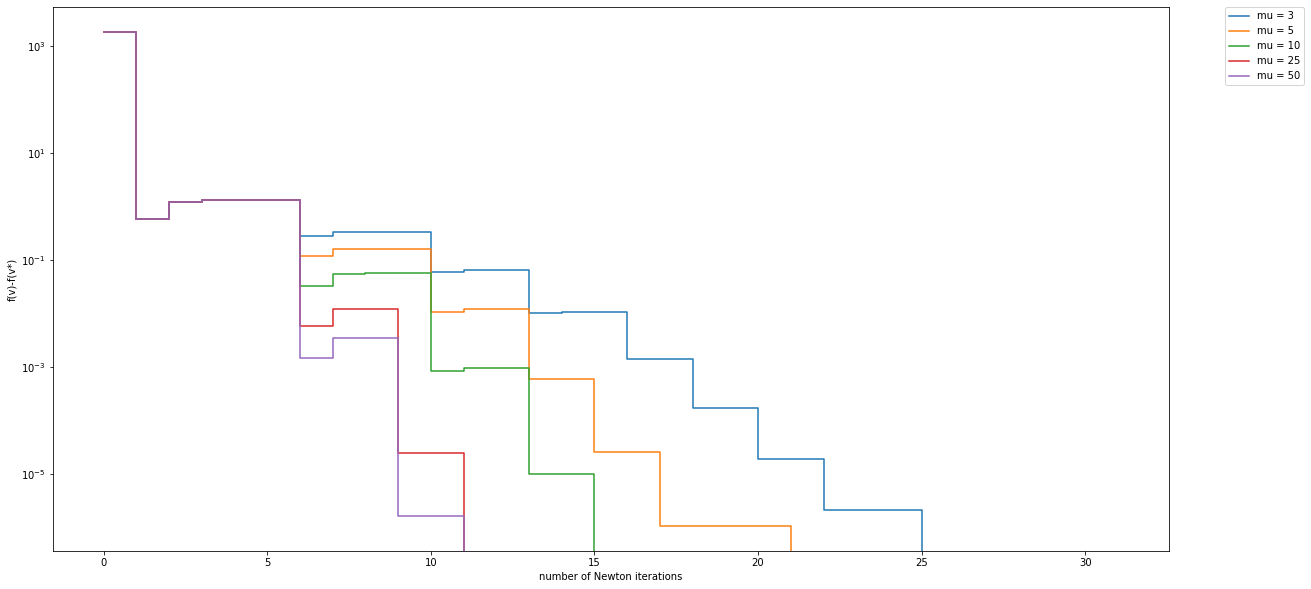

In [136]:
# On essaie différentes valeurs de mu
f = fct(listA,listb)
mus = [3,5,10,25,50]
plt.figure(figsize=(20,10))
for mu in mus:
    v = barr_method(listA, listb, z, R, d, v0,eps,crit,t0=1,mu=mu)[0]
    plt.step([i for i in range(len(v))],[f(u)-f(v[-1]) for u in v], label="mu = "+str(mu))
    plt.yscale("log")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('f(v)-f(v*)')
plt.xlabel('number of Newton iterations')
plt.show()

(35, 35, 15)
(18375, 19) (18375,) 15 15 (1225, 19)


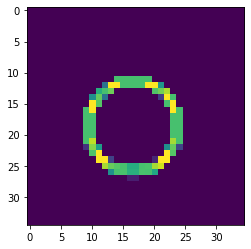

In [208]:
W = W_mat(particle,framesInter)
print(W.shape)
plt.imshow(W[:,:,10])

A, b, listA, listb = Create_A_and_b(W)
print(A.shape, b.shape, len(listA), len(listb), listA[0].shape)


In [199]:
# definis dans la simulation plus haut
R = Radius*zoomfactor
d = np.sqrt(nx**2+ny**2)
z = framesInter
print(R,d**2, z)
realcenter = center*nx


a = np.floor(realcenter)[0]
b = np.floor(realcenter)[1]
xsi = a**2+b**2+100
eta = 3*np.ones(len(z))
v0 = np.concatenate((np.floor(realcenter),[xsi],eta))
v0[0:3]+=0.8
print(realcenter)
print(v0)

eps=1e-6
crit=1e-6



8.0 2450.0 [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
[19.23849954 17.01607495 19.76690988]
[ 19.8  17.8  19.8 750.    3.    3.    3.    3.    3.    3.    3.    3.
   3.    3.    3.    3.    3.    3.    3. ]


In [200]:
# Il faut bien initialiser

constr1 = v0[4:]
constr2 = -( (v0[2]-z)**2 - R**2)
constr3 = [-(v0[0]**2 + v0[1]**2 - v0[3])]
constr4 = [-(v0[3] - d**2)]
print(constr1)
print(constr2)
print(constr3)
print(constr4)

[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
[ 3.16 17.76 30.36 40.96 49.56 56.16 60.76 63.36 63.96 62.56 59.16 53.76
 46.36 36.96 25.56]
[41.11999999999989]
[1700.0]


In [201]:
res = barr_method(listA, listb, z, R, d, v0,eps,crit,t0=1,mu=25)[0][-1]
print(res)
print(res[0:3]-realcenter)

f(v) =  3057409.1756247617
f(v) =  105375.07084602224
f(v) =  105365.55858452783
f(v) =  105365.174737094
f(v) =  105365.15942683358
f(v) =  105365.15881274227
[1.87105838e+01 1.65378492e+01 1.84567543e+01 6.31101621e+02
 1.71336455e+01 1.34379426e+01 1.16443466e+01 8.80471893e+00
 7.08061847e+00 1.98763428e-09 3.45741180e-10 1.23610878e-10
 6.89125882e-11 4.88111673e-11 4.11250515e-11 3.90049179e-11
 4.17060519e-11 5.38814500e-11 1.00597490e-10]
[-0.52791576 -0.47822578 -1.31015555]


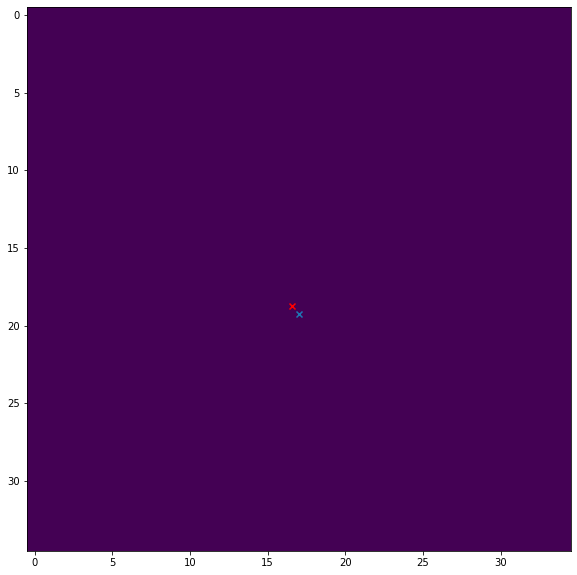

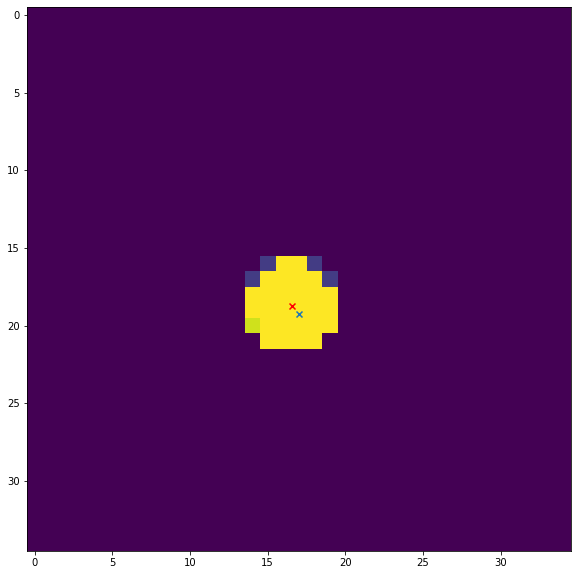

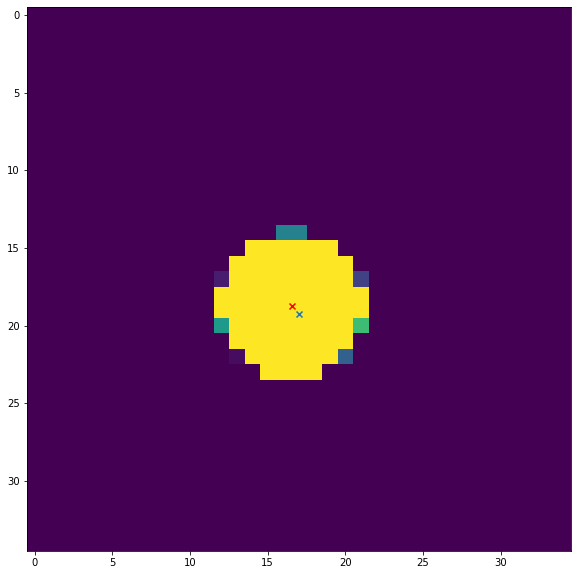

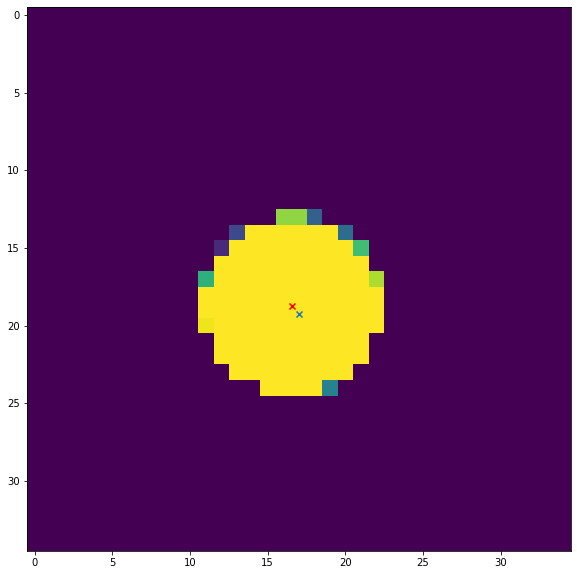

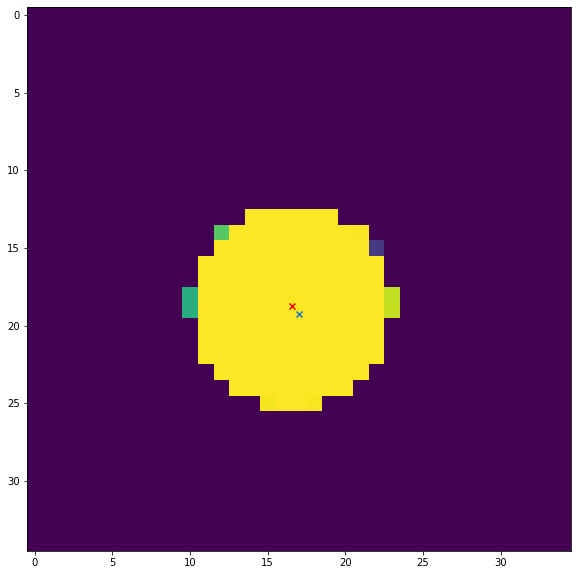

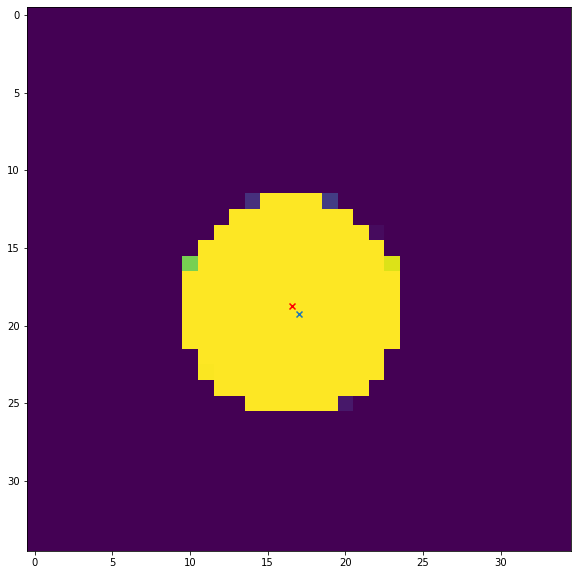

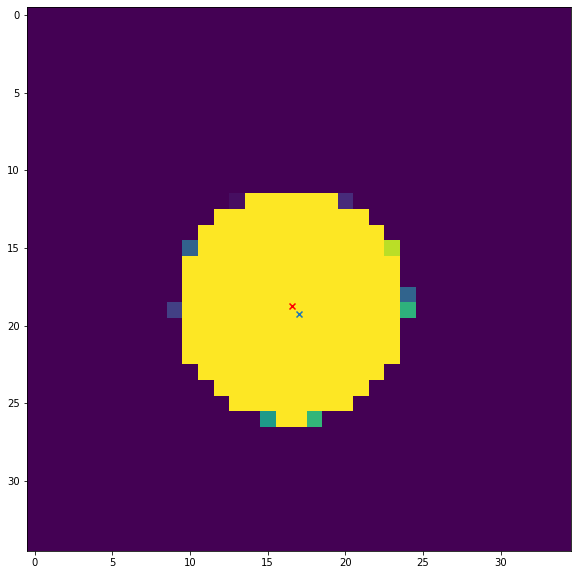

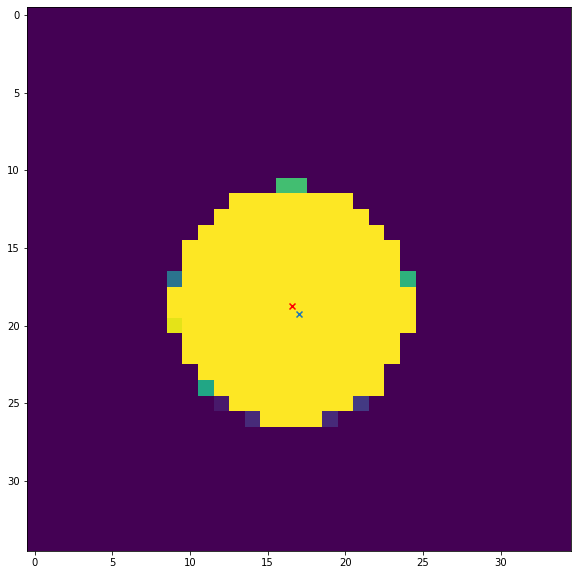

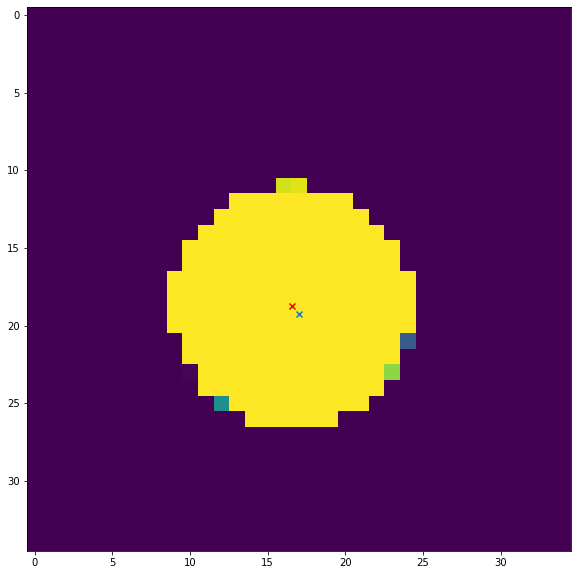

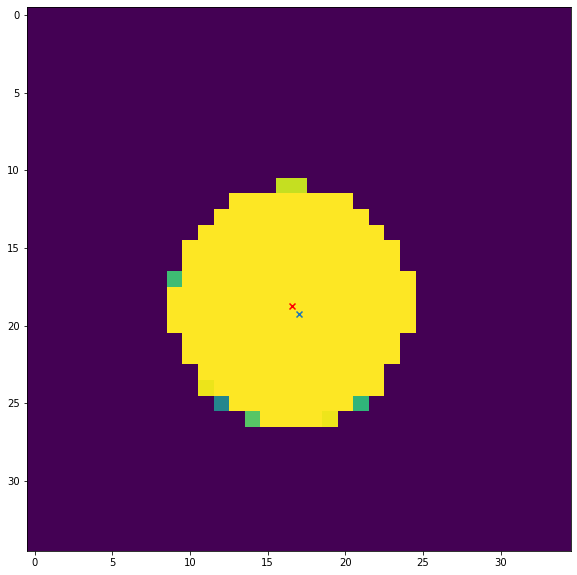

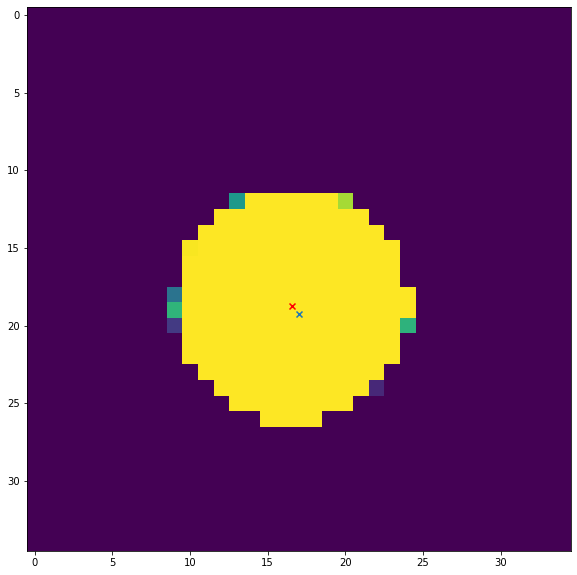

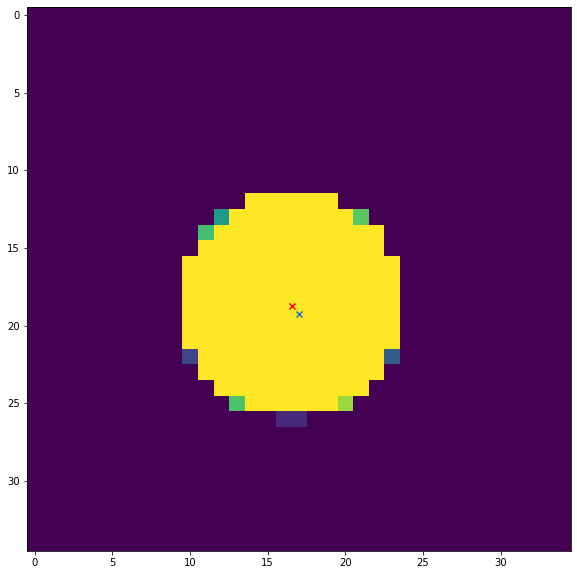

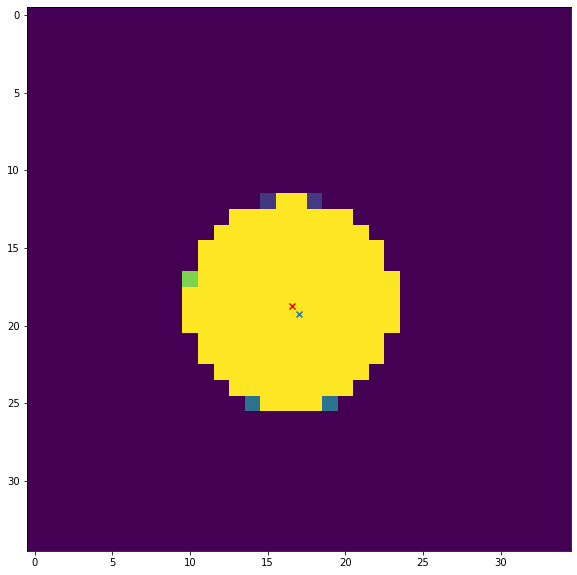

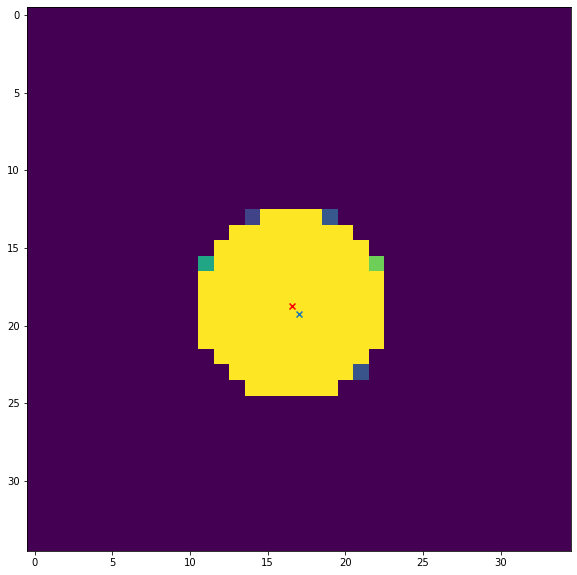

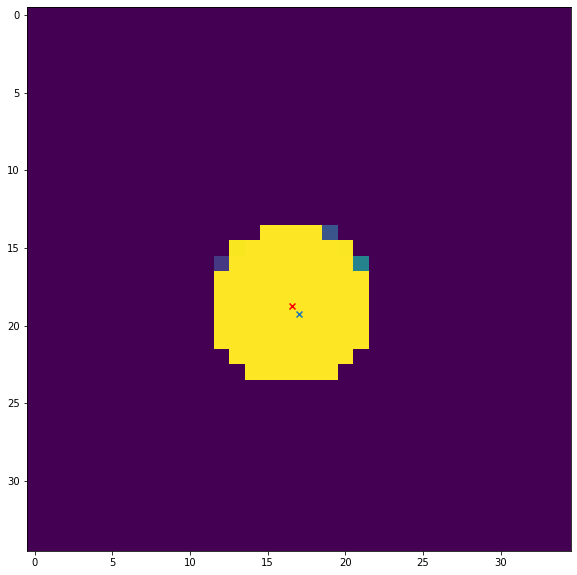

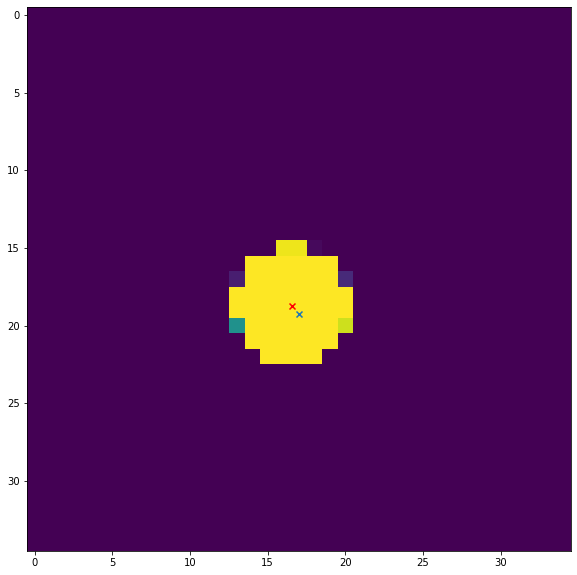

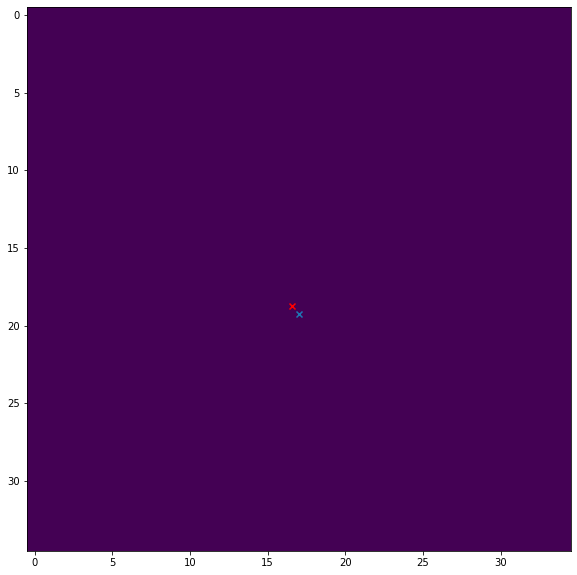

In [202]:
Z = int(nz*center[2])

for i in range(-8,9,1):
    plt.figure(figsize=(20,10))
    plt.imshow(particle[:,:,Z+i])
    plt.scatter([nx*center[1]],[ny*center[0]], marker="x")
    plt.scatter([res[1]],[res[0]], marker="x", color='red')
    plt.show()

f(v) =  3057409.1756247617
f(v) =  105375.07084602224
f(v) =  105368.47996565324
f(v) =  105366.26836445516
f(v) =  105365.52895725118
f(v) =  105365.28221861165
f(v) =  105365.19993444633
f(v) =  105365.1724642938
f(v) =  105365.16333349043
f(v) =  105365.16029961167
f(v) =  105365.1592930134
f(v) =  105365.15894295789
f(v) =  105365.15884044136
f(v) =  105365.15880216192
f(v) =  105365.15879373615
f(v) =  105365.15879066144
f(v) =  3057409.1756247617
f(v) =  105375.07084602224
f(v) =  105367.15398201226
f(v) =  105365.55857037325
f(v) =  105365.23877460333
f(v) =  105365.1747866428
f(v) =  105365.16195140907
f(v) =  105365.15942595367
f(v) =  105365.1589053654
f(v) =  105365.15881234067
f(v) =  105365.15879134901
f(v) =  3057409.1756247617
f(v) =  105375.07084602224
f(v) =  105366.15745527112
f(v) =  105365.25860201987
f(v) =  105365.16873354414
f(v) =  105365.1597745638
f(v) =  105365.15888519332
f(v) =  105365.15879693393
f(v) =  3057409.1756247617
f(v) =  105375.07084602224
f(v) =

DEBUG:matplotlib.ticker:vmin 2.626589729783804e-07 vmax 12347703.433965309
DEBUG:matplotlib.ticker:ticklocs array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05,
       1.e+07, 1.e+09, 1.e+11])
DEBUG:matplotlib.ticker:vmin 2.626589729783804e-07 vmax 12347703.433965309
DEBUG:matplotlib.ticker:ticklocs array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05,
       1.e+07, 1.e+09, 1.e+11])
DEBUG:matplotlib.ticker:vmin 2.626589729783804e-07 vmax 12347703.433965309
DEBUG:matplotlib.ticker:ticklocs array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05,
       1.e+07, 1.e+09, 1.e+11])
DEBUG:matplotlib.ticker:vmin 2.626589729783804e-07 vmax 12347703.433965309
DEBUG:matplotlib.ticker:vmin 2.626589729783804e-07 vmax 12347703.433965309
DEBUG:matplotlib.ticker:ticklocs array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05,
       1.e+07, 1.e+09, 1.e+11])
DEBUG:matplotlib.ticker:vmin 2.626589729783804e-07 vmax 12347703.433965309
DEBUG:

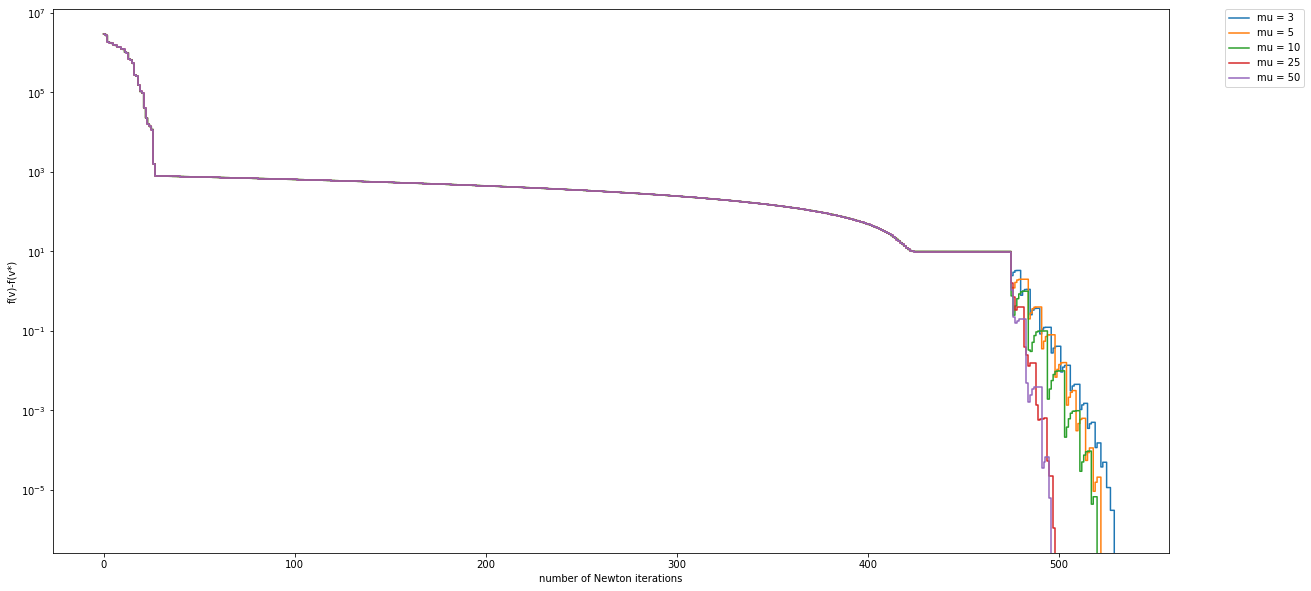

In [203]:
# On essaie différentes valeurs de mu
f = fct(listA,listb)
mus = [3,5,10,25,50]
plt.figure(figsize=(20,10))
for mu in mus:
    v = barr_method(listA, listb, z, R, d, v0,eps,crit,t0=1,mu=mu)[0]
    plt.step([i for i in range(len(v))],[f(u)-f(v[-1]) for u in v], label="mu = "+str(mu))
    plt.yscale("log")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('f(v)-f(v*)')
plt.xlabel('number of Newton iterations')
plt.show()